### Pneumonia Dataset from Kaggle 
Link: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia<br>
Reference: Kermany, Daniel; Zhang, Kang;  Goldbaum, Michael (2018), "Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification", Mendeley Data, v2. DOI: 10.17632/rscbjbr9sj.2.
_________________
<table align="left">
    <tr>
        <th>Pneumonia</th>
        <th>Normal</th>
        <th>Total</th>
    </tr>
    <tr>
        <td style="text-align: center;">4273</td>
        <td style="text-align: center;">1583</td>
        <td style="text-align: center;">5863</td>
    </tr>
</table>

In [15]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

import warnings
warnings.simplefilter("ignore")

# cnn
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer 
from sklearn.metrics import balanced_accuracy_score

import seaborn as sns

### Carregamento dos Dados

In [2]:
datadir = "C:\\Users\\robso\\CNN Pneumonia\\Data\\"
categories = ['Normal', 'Pneumonia']
x = []
y = []

for category in categories:
    path = os.path.join(datadir, category)
    
    for i in os.listdir(path):
        image = cv2.imread(os.path.join(path, i), cv2.IMREAD_GRAYSCALE)
        image = resize(image, (128, 128, 3), mode = 'constant', preserve_range = True)
        image = np.array(image)
        image = image.astype('float32')
        image /= 255
        x.append(image)
        y.append(categories.index(category))

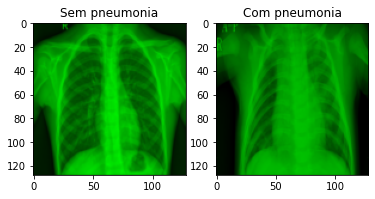

In [3]:
plt.subplot(121)
plt.title('Sem pneumonia')
plt.imshow(x[0])
plt.subplot(122)
plt.title('Com pneumonia')
plt.imshow(x[3000])

### Divisão do Conjunto de Dados

In [4]:
x = np.array(x)
y = np.array(y)

x2, x_test, y2, y_test = train_test_split(x, y, test_size=0.1, shuffle=True, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size=0.2, shuffle=True, stratify=y2)

inputs = np.concatenate((x_train, x_val), axis=0)
targets = np.concatenate((y_train, y_val), axis=0)

### Arquitetura e Treinamento da CNN

In [12]:
model = Sequential()
model.add(Flatten(input_shape=(128,128,3)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.001), 
                loss='binary_crossentropy',
                metrics=['accuracy'])

model.summary()
    
results = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               6291584   
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 129       
Total params: 6,291,713
Trainable params: 6,291,713
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
132/132 [==============================] - 13s 81ms/step - loss: 1.2802 - accuracy: 0.6797 - val_loss: 0.3596 - val_accuracy: 0.8368
Epoch 2/10
132/132 [==============================] - 7s 53ms/step - loss: 0.3780 - accuracy: 0.83

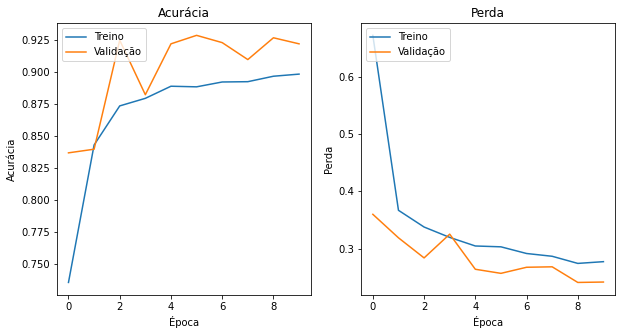

In [13]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.legend(['Treino', 'Validação'], loc='upper left')

plt.subplot(122)
plt.title('Perda')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.legend(['Treino', 'Validação'], loc='upper left')

plt.show()

In [17]:
def model_grid(n,learn_rate,dropout):
    model = Sequential()
    model.add(Flatten(input_shape=(128,128,3)))
    model.add(Dense(n, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(lr=learn_rate), 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

lr_grid = [0.001]
n_grid = [128]
dropout_grid = [0.2,0.3,0.4,0.5]

param_grid = dict(learn_rate=lr_grid, n=n_grid, dropout=dropout_grid)

model = KerasClassifier(build_fn=model_grid, epochs=10, batch_size=64, verbose=0)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, refit=False)
grid_result = grid.fit(x2, y2)

df = pd.DataFrame(grid_result.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dropout,param_learn_rate,param_n,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,37.291600,3.685299,1.060123,0.076009,0.2,0.001,128,"{'dropout': 0.2, 'learn_rate': 0.001, 'n': 128}",0.918042,0.932840,0.915148,0.922010,0.007749,1
1,37.133087,6.235082,1.231806,0.390308,0.3,0.001,128,"{'dropout': 0.3, 'learn_rate': 0.001, 'n': 128}",0.734206,0.932271,0.924829,0.863769,0.091665,4
2,37.690914,5.695335,0.969075,0.157414,0.4,0.001,128,"{'dropout': 0.4, 'learn_rate': 0.001, 'n': 128}",0.894707,0.931133,0.930524,0.918788,0.017030,2
3,33.617566,1.491004,2.842019,2.675454,0.5,0.001,128,"{'dropout': 0.5, 'learn_rate': 0.001, 'n': 128}",0.918611,0.927149,0.909453,0.918404,0.007226,3


### Teste da CNN

In [ ]:
y_pred = model.predict(x_test)
y_pred = np.round(y_pred)

cmat=confusion_matrix(y_test,y_pred,labels=[0,1])
cm_df = pd.DataFrame(cmat)

tp = cmat[1][1]
fp = cmat[0][1]
tn = cmat[0][0]
fn = cmat[1][0]

accuracy = ((tp+tn)*100)/np.sum(cmat)
precision = (tp*100)/(tp+fp)
sensibility = (tp*100/(tp+fn))
specificity = (tn*100)/(fp+tn)

print('Métrica de avaliação\t\tResultado')
print('---------------------------------------------')
print('Acurácia:\t\t',accuracy,"%")
print('Precisão:\t\t',precision,"%")
print('Sensibilidade:\t\t',sensibility,"%")
                   
plt.title('Teste')
sns.heatmap(cm_df, annot=True, fmt="d", cmap=plt.cm.Oranges)
plt.show()

In [ ]:
fpr_cnn, tpr_cnn, threshold_cnn = roc_curve(y_test, y_pred)
auc_cnn = auc(fpr_cnn, tpr_cnn)

plt.figure(1)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_cnn, tpr_cnn, label='AUC: {:.4f}'.format(auc_cnn))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()